# AUTOENCODERS FOR FRAUD DETECTION

This notebook explores the use of autoencoders as a step in approaching classification in imbalanced datasets. 

Fundamentally, autoencoders are neural networks that take data as their input and attempt to reconstruct that data as it's output. This by having a hidden layer(s) of smaller size than the input. This will allow the model to learn a compressed, more concise representation of the input features with fewer dimension that the input. These compressed features translate to the non-linear combination of the input features that are characteristic of the input and the most useful in in the reconstruction of the data. The model will then use those features to reconstruct the input.

So why would would we want to recreate the input? What does this have to do with classification in imbalanced datasets?

The problem with imbalanced datasets is that even a very simple classifier can achieve high accuracy score by all observations as the majority class. If a dataset has 90% class A and 10% class B with the model predicting class A for all observations, then the model will still achieve a 90% accuracy. The model hasn't really learned anything about the data and is just taking advantage of the disproportionate representation of the classes. This shows a failure of some models in handling imbalanced datasets as well as the failure of accuracy as a metric in evaluating models that deal with imbalanced datasets. 

For the first problem oversampling of the majority class, undersampling of the minority class, or both can help achieve balance in the number of observations of each class. Many models also allows for class weight parameters that assign more weight to misclassification of the minority class to pressure the model to learn how to classify it better. Strategies to tackles the second problem include using precision, recall and f1-scores in conjunction to score, tune and evaluate a model. 

Which brings us to autoencoders. If we train an autoencoder on ONLY the features of the majority class in a binary classification, the model will learn a characteristic representation of the precitor features of that class and how to reconstruct it. Since the model has only seen the majority class thus far, it should theoretically be able to reconstruct that data with a lower error than any unseen data. As a result, when the autoencoder is fed the data from the minority class, it will reconstruct it with a higher error. By exploring the difference in that reconstruction error we should be able to tell which class an observation belongs.

Let's explore a use case for this in Fraud Detection Analytics. When developing fraud detection algorithms, companies have access to large amounts of transactional data, most of which belongs to legitimate/normal transactions. They have relatively few data points corresponding to fraudulent transactions which pose a challenge in developing the algorithms to detect them for the reasons discussed above. 

The dataset for fraud detection is provided by Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

# Loading Libraries

In [228]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from tensorflow import keras
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers, backend
sb.set(style='white', font_scale=1.75)

#### Exploring Data

In [229]:
#loading data from file
credit_df = pd.read_csv("./creditcard.csv")

In [230]:
#exploring data types and non-null values
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

There are 284,807 observations and 31 variables. Time, Amount and variables with prefix V are the predictor variables with Class being the target variable for the classification.

There are no NULL values in the dataset and all variables are provided as floats with the exception of the target variable which is a binary variable. These feature types are expected and do not need to be converted.

In [231]:
#computing descriptive statistics
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The feature are of different scales and so a scaling preprocessing step will be necessary.

In [232]:
#preview of 10 rows of data
credit_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


The features provided in this dataset are:

Time: The time, in hours, since the first transaction in the dataset.
V1-V28: Principal Component Transformation of features for the sake of privacy of users.
Amount: Transaction Amount in US Dollars
Class: Indicator of whether the transaction is normal (0) or fraud (1).

In [233]:
#exploring target variable distribution
credit_df['Class'].value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

#### Preliminary Preprocessing

Let's start by checking for and removing duplicate transactions.

In [234]:
#checking for duplicates
credit_df.duplicated().any()

True

In [235]:
#finding out how many duplicates
credit_df.duplicated().value_counts()

False    283726
True       1081
dtype: int64

There are 1081 duplicated transactions that should be removed since they are just repeated information.

In [236]:
#dropping duplicate rows
credit_df = credit_df.drop_duplicates()

Now let's convert the units on the time feature

In [237]:
#converting time to hours
credit_df['Time'] = credit_df['Time']/3600

And finally scaling the time and amount features

In [238]:
#making a copy before scaling
X = credit_df.copy()

In [239]:
#scaling
X['Time'] = scale(X['Time'])
X['Amount'] = scale(X['Amount'])

#### Splitting Data

Since we have a lot of observations we can afford to allocated 50% towards training with the other 50% being used for validation and testing. 30% will be validation and 20% will be testing.

In [240]:
#splitting training and testing
X_train, X_test = train_test_split(X, test_size = 0.5, stratify = X['Class'], random_state = 123)

In [242]:
#splitting testing and validation
X_test, X_val = train_test_split(X_test, test_size = 0.6, stratify = X_test['Class'], random_state = 123)

We only need the predictor features of the normal class from the training set to train the an autoencoder model so let's extract that.

In [243]:
#isolating the 'normal' class examples from the training set
X_train = X_train[X_train['Class']==0]
#dropping the label column
X_train = X_train.drop(columns = 'Class')

For the validation and testing we need the predictor features and the target variables

In [244]:
#isolating target variable and predictor features for validation
y_val = X_val['Class']
X_val = X_val.drop(columns = 'Class')
#repeating for testing
y_test = X_test['Class']
X_test = X_test.drop(columns = 'Class')

#### Model Construction

The parameters chosen for the model are simply compressions of a factor of 2 at every step. Since the input data has 30 features, the first layer was chosen as 15 features and the next as 7. These first two layers are known as the encoders since they compress/encode data to extract the characteristic representation. The reverse process is the decoding done by the decoders. For this case, the layers were chosen as symmetric to the encoders but they don't necessarily have to be. Optimizing autoencoders is a topic that could be explored in future notebooks. A mixture of elu and tanh activations were used as the activation functions. The first encoding layer has an l1 sparsity regularization as a penalty on weights so that the model keeps only the most useful ones towards the reconstruction.

Since we are dealing with continous variables in reconstruction the loss function chosen was mean squared error. Adam optimizer was used with accuracy as the metric to determine reconstruction quality.

In [245]:
#defining model parameters
INPUT_DIM = X_train.shape[1]
ENCODING_DIM = 15
HIDDEN_DIM = 7
SPARSITY = 1e-7

In [246]:
#constructing model
input_layer = Input(shape=(INPUT_DIM, )) 
encoder = Dense(ENCODING_DIM, activation = "elu", kernel_regularizer = regularizers.l1(SPARSITY))(input_layer)
encoder = Dense(HIDDEN_DIM, activation = "tanh")(encoder)
decoder = Dense(ENCODING_DIM, activation = "elu")(encoder)
output_layer = Dense(INPUT_DIM, activation = 'elu')(decoder)
autoencoder = Model(inputs=input_layer, outputs = output_layer)

In [247]:
#compiling model
autoencoder.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['accuracy'])

In [248]:
#defining early stopping condition
es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [249]:
#fitting model to training data (for input and output!)
BATCH_SIZE = 128
EPOCHS = 100

history = autoencoder.fit(X_train, X_train, validation_data = (X_val, X_val), epochs = EPOCHS,
                         batch_size = BATCH_SIZE, shuffle = True, callbacks = [es])

Train on 141626 samples, validate on 85118 samples
Epoch 1/100
141626/141626 [==============================] - 3s 24us/step - loss: 0.7066 - accuracy: 0.4870 - val_loss: 0.6603 - val_accuracy: 0.5830
Epoch 2/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.5917 - accuracy: 0.6019 - val_loss: 0.6183 - val_accuracy: 0.6154
Epoch 3/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.5611 - accuracy: 0.6280 - val_loss: 0.5957 - val_accuracy: 0.6370
Epoch 4/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.5429 - accuracy: 0.6446 - val_loss: 0.5814 - val_accuracy: 0.6491
Epoch 5/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.5297 - accuracy: 0.6538 - val_loss: 0.5686 - val_accuracy: 0.6541
Epoch 6/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.5172 - accuracy: 0.6593 - val_loss: 0.5565 - val_accuracy: 0.6606
Epoch 7/100
141626/141626 [======================

Epoch 55/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.4410 - accuracy: 0.6987 - val_loss: 0.4837 - val_accuracy: 0.6954
Epoch 56/100
141626/141626 [==============================] - 3s 21us/step - loss: 0.4409 - accuracy: 0.6987 - val_loss: 0.4837 - val_accuracy: 0.6967
Epoch 57/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.4406 - accuracy: 0.6988 - val_loss: 0.4829 - val_accuracy: 0.6972
Epoch 58/100
141626/141626 [==============================] - 3s 21us/step - loss: 0.4406 - accuracy: 0.6987 - val_loss: 0.4835 - val_accuracy: 0.6939
Epoch 59/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.4404 - accuracy: 0.6989 - val_loss: 0.4830 - val_accuracy: 0.6942
Epoch 60/100
141626/141626 [==============================] - 3s 21us/step - loss: 0.4403 - accuracy: 0.6986 - val_loss: 0.4834 - val_accuracy: 0.6952
Epoch 61/100
141626/141626 [==============================] - 3s 22us/step - loss: 0.4401 - ac

Text(0.5, 1.0, 'Metrics vs Training Epochs')

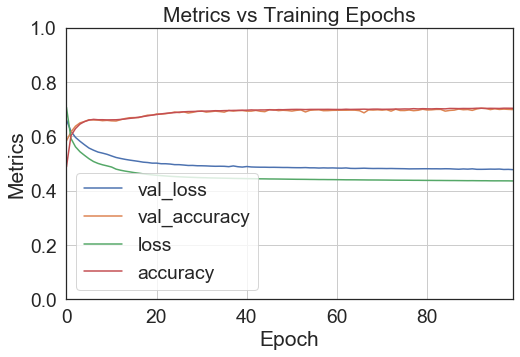

In [255]:
#plotting model history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Metrics vs Training Epochs')

Now that we have built, compiled and training the model, we can use the validation data to define our error threshold and then see how it performs on unseen data.

#### Evaluation

Let's start by attempting to reconstruct the validation data

In [251]:
#reconstructing validation data
pred = autoencoder.predict(X_val)

Using mean squared error as the metric, we evaluate the reconsturction error of the validation set and store it in a dataframe.

In [252]:
#calculating reconstruction error for validation data, mean-squared error metric.
error = pd.DataFrame(np.mean(np.power(pred - X_val, 2), axis = 1), columns = ['error'])

Our validations set, unlike our training set, has observations of BOTH normal and fradulent classes. Let's see how the errors compare across the classes.

In [253]:
# pd.DataFrame(normal_error).median()
error[y_val==0].describe()

,error
count,84976.000000
mean,0.439734
std,5.469198
min,0.010856
25%,0.102952
50%,0.175767
75%,0.326907
max,1375.361421


In [254]:
# pd.DataFrame(fraud_error).median()
error[y_val==1].describe()

,error
count,142.000000
mean,22.825013
std,34.580720
min,0.090783
25%,2.996824
50%,7.426743
75%,22.837631
max,238.691554


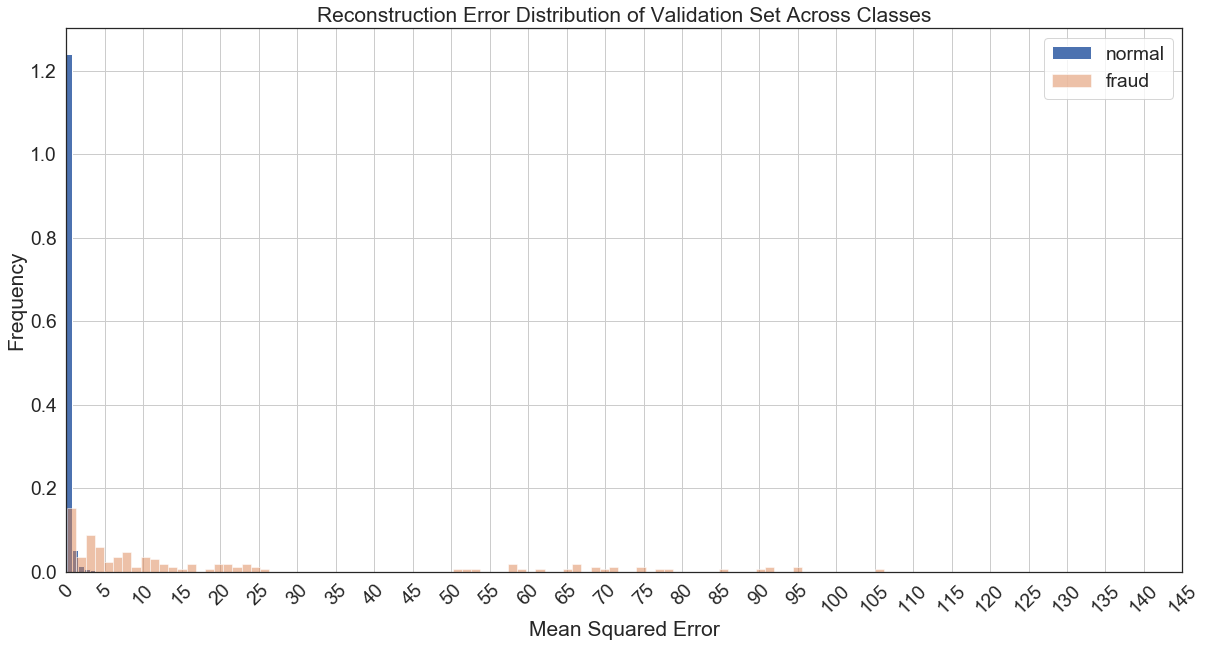

In [279]:
plt.figure(figsize = (20, 10));
plt.hist(error[y_val==0].values, bins = 200, range = (0, 150), density = True, alpha = 1, label = 'normal');
plt.hist(error[y_val==1].values, bins = 200, density = True, alpha = 0.5, label = 'fraud');
plt.legend();
plt.xlim((0, 145));
plt.xticks(np.arange(0, 150, 5), rotation = 45);
plt.grid()
plt.xlabel('Mean Squared Error');
plt.ylabel('Frequency');
plt.title('Reconstruction Error Distribution of Validation Set Across Classes');

Here we see the intended result. The autoencoder has managed to achieve low errors in the reconstruction of the normal class which it was trained on. Since the fraud class was not seen in training, the autoencoder expectedly struggles to reconstruct it, resulting in relatively higher reconstruction erorrs. 

The separation between the two is clear but not perfect, there is some overlap in with errors of about less than 4. For demonstration purposes, the threshold will selected from visual inspection as 4. We will predict fraudulent for any observation which the autoencoder's reconstruction yield an error of 4 or above. Anything else will be predicted as normal. 

Depending on the application though, the threshold may be selected with a metric in mind. In the real-world the decisions have consequences and costs. It might cost more to misclassify one class over the other, or false negatives might be less desirable than false positives. These are things to keep in mind when making a decision.

In [281]:
#setting threshold
threshold = 4

Finally, we can move on to our unseen test data and see how the model performs. Following similar steps as above we will attempt to reconstruct the data using our autoencoder, quantify the reconstruction error, and lastly compare the reconstruction error against our threshold. If it's greater than or equal to 4, we will predict that the transaction is fraudulent, otherwise we will predict normal/legitimate.

In [282]:
#reconstructing the test data with the autoencoder
X_pred = autoencoder.predict(X_test)

In [283]:
#calculating reconstruction error
error_X = np.mean(np.power(X_test - X_pred, 2), axis = 1)

In [284]:
#making prediction by comparing reconstruction error to threshold
y_pred = [1 if x>=threshold else 0 for x in error_X]

### Model Performance Metrics

In [285]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.09      0.68      0.17        94

    accuracy                           0.99     56745
   macro avg       0.55      0.84      0.58     56745
weighted avg       1.00      0.99      0.99     56745



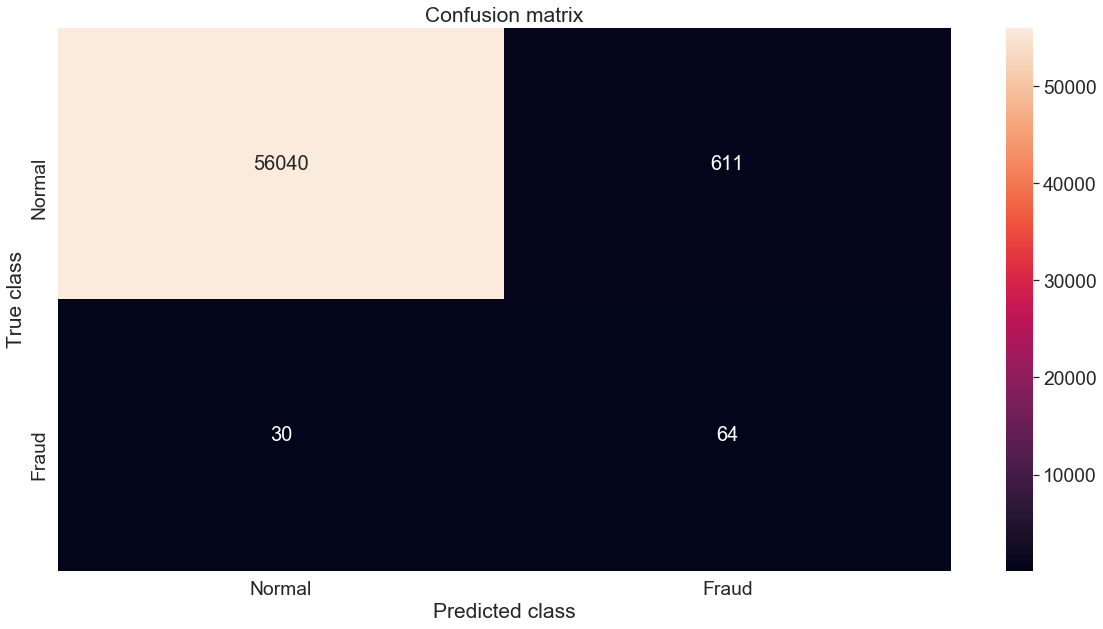

In [286]:
labels = ['Normal', 'Fraud']
plt.figure(figsize = (20, 10))
cm = confusion_matrix(y_test, y_pred)
sb.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt = 'g', annot_kws={"size": 20})
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Text(0.5, 0, 'False Positive Rate')

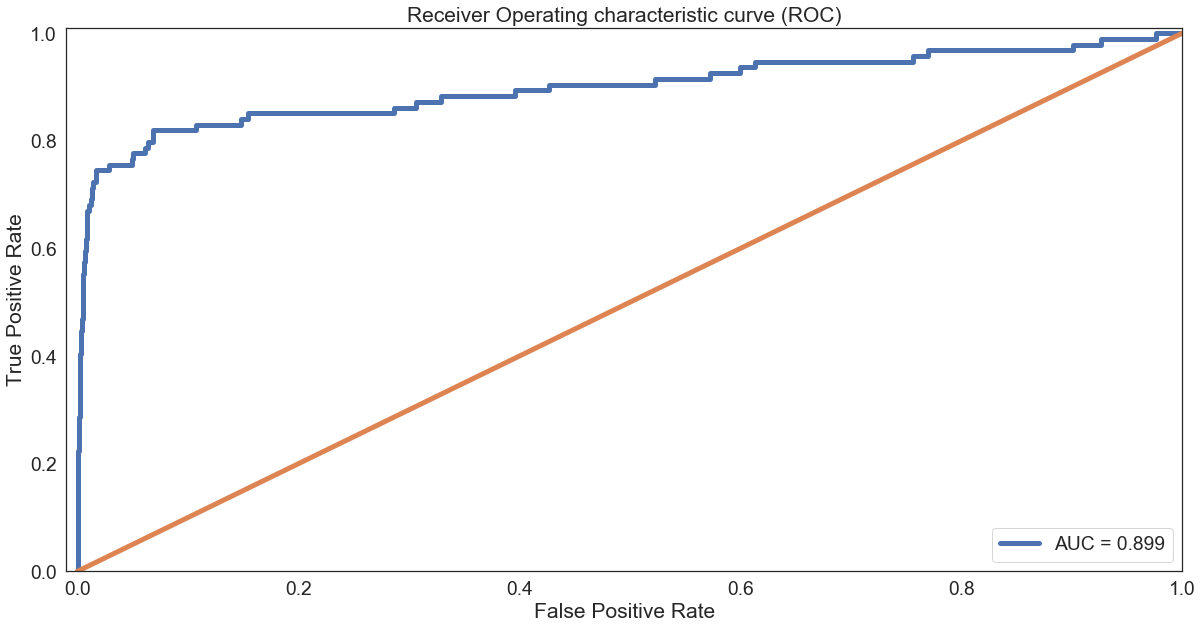

In [289]:
#plotting Receiver Operating Characteristic Curve
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, error_X)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize = (20, 10))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver Operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

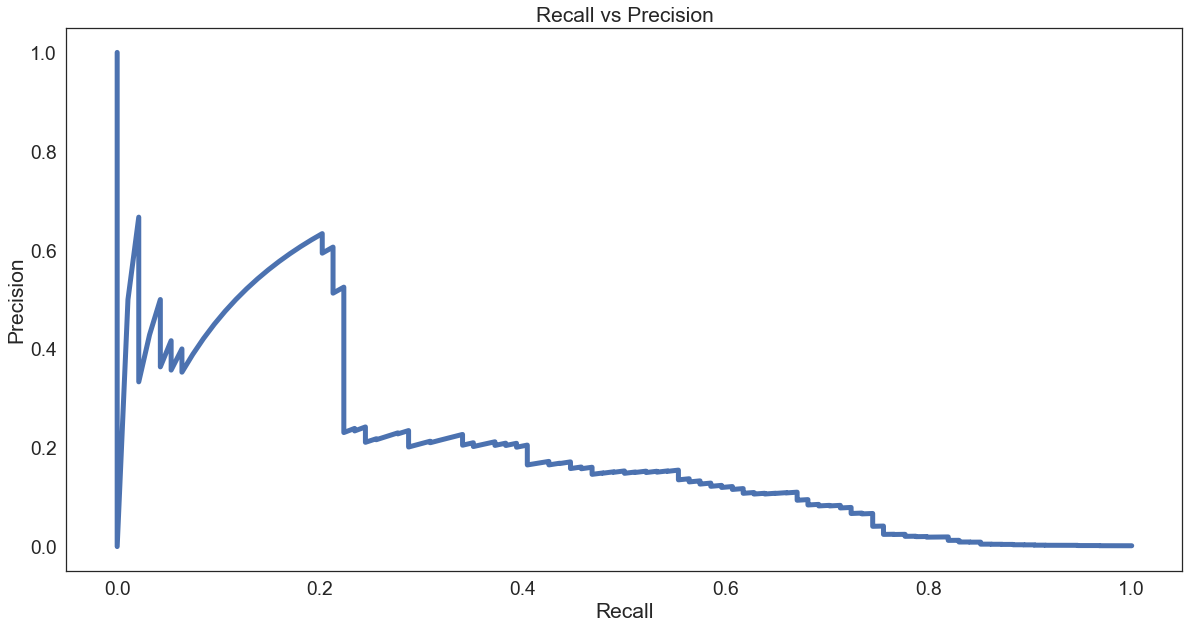

In [291]:
#Plotting recall vs precision
plt.figure(figsize = (20, 10))
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_test, error_X)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

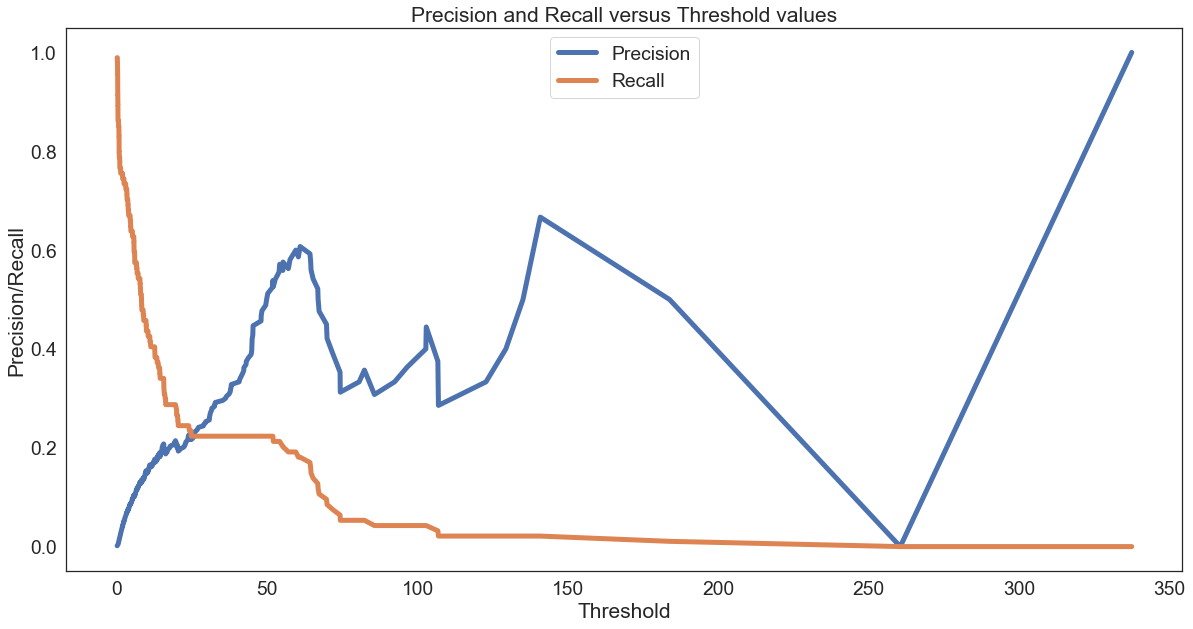

In [290]:
#plotting Precision-Recall vs Threshold
plt.figure(figsize = (20, 10))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and Recall versus Threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Depending on the above plot, the threshold we defined earlier can be adjusted to achieve the desired tradeoff between precision and recall that best suits the application at hand